In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# Define parameters

grid_size = (20, 20)
np.random.seed(123)
criminality = np.random.rand(*grid_size) # Define the initial criminality for every cell
education = np.random.rand(*grid_size) # Define the education for every cell (here fixed, but can be linked to data in final model)
income = np.random.rand(*grid_size) # Define the income for every cell (here fixed, but can be linked to data in final model)
alpha = 0.3 # Assign weight for influence of criminality in own neighbourhood
beta = 0.7 # Assign weight for influence of criminality in other neighbourhoods

In the following cell, we set up the model such that, in each time period, we update the criminality level $C$ of each cell based on the transition function:

$$ C_{t+1} =  \alpha C_t + (\beta (1 - \gamma)) M + \frac{\beta}{2} L$$

where $\alpha$ controls the sensitivity of the new level of criminality to the cell-self old criminality, $\beta$ controls the sensitivity to the neighbors situation, $\gamma$ calibrates the dependence of sensitivity to neighbors based on education and income, $M$ represents neighbors with more criminality than the cell of interest and $L$ the ones with less criminality. This distinction is necessary, since a higher education/income should reduce the sensitivity to higher criminality, but not to lower.

In [3]:
# Define functions to run simulation

def update_cell(x, y, criminality, education, income): # Update the criminality of a cell based on its neighbours nad itself

    current_state = criminality[x, y]
    neighbors = criminality[max(0, x-1):x+2, max(0,y-1):y+2] # Get the 8 neighbours of the cell
    neighbors = np.delete(neighbors, (neighbors.shape[0] // 2, neighbors.shape[1] // 2)) # Remove the cell itself from the neighbours

    # Here we distinguish between neighbours with more criminality and neighbours with less criminality
    less_crim_influence = np.mean(neighbors[neighbors <= current_state]) if np.any(neighbors <= current_state) else 0
    more_crim_influence = np.mean(neighbors[neighbors > current_state]) if np.any(neighbors > current_state) else 0

    gamma = np.mean([education[x, y], income[x, y]]) # Here we calculate the average sensitivity of the cell to "external" criminality, so that higher education/income result in lower sensitivity (following line)

    # Here we calculate the influence of neighbors distinguishing between more and less criminality (compared to the cell itself) because higher education/income should lower the sensitivity to more criminality but not to less criminality
    weight_more = beta * np.clip(1 - gamma, 0.1, 0.9) # We clip the value to avoid the weight to be 0
    weight_less = beta / 2

    # Here we calculate the new criminality of the cell based on the criminality of the cell itself and the influence of the neighbours
    new_state = (
        alpha * current_state +
        weight_less * less_crim_influence +
        weight_more * more_crim_influence
    )
    return np.clip(new_state, 0, 1)

def update_grid(criminality, education, income): # Update the criminality of the whole grid based on the update_cell function
    new_criminality = np.zeros_like(criminality)
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            new_criminality[x, y] = update_cell(x, y, criminality, education, income)
    return new_criminality

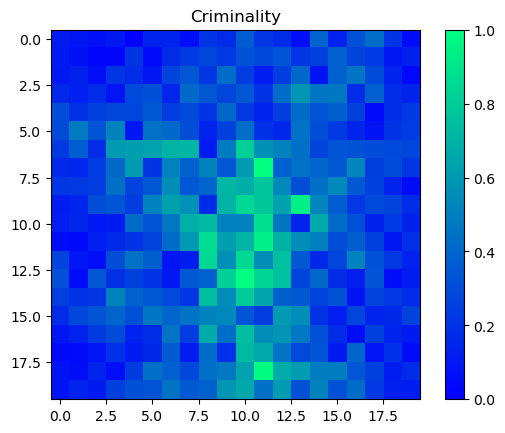

In [4]:
# Run the simulation and output the results as animation

def animate(t):
    global criminality
    criminality = update_grid(criminality, education, income)
    cax.set_array(criminality)
    return cax

fig, ax = plt.subplots()
cax = ax.imshow(criminality, cmap='winter', vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)
ax.set_title('Criminality')

timesteps = 300

ani = FuncAnimation(fig, animate, frames=timesteps, interval=500)

HTML(ani.to_jshtml())